#  SAXSA Explorador Financiero
Uso de DASH para visualización de valores de cotización de acciones en la bolsa

Dash abstrae todas las tecnologías y protocolos necesarios para crear una aplicación interactiva basada en la web y es una manera simple y efectiva de enlazar una interfaz de usuario en torno a su código Python.
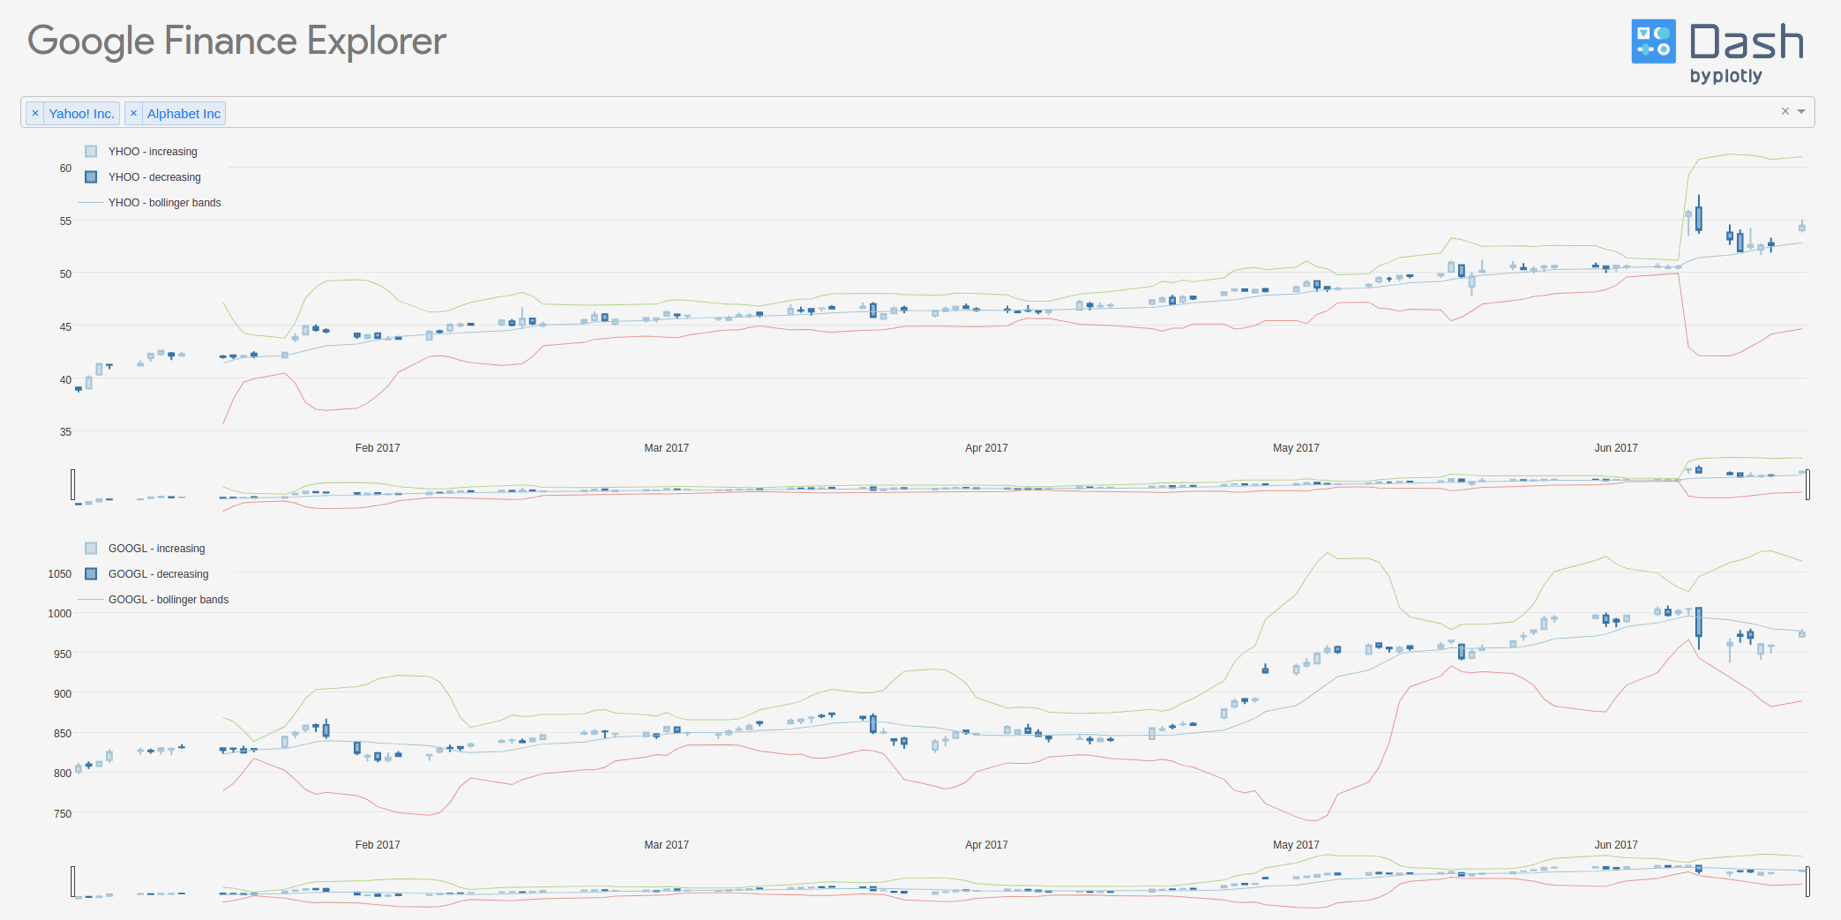

Al ejecutar la applicacion (app.py), Esta se desplegara en http://localhost:8050.


In [1]:
# -*- coding: utf-8 -*-

#Importamos las librerias requeriadas para trabajar con dash
import dash
import dash_core_components as dcc
import dash_html_components as html

# Importamos bibliotecas que de manejo colores y de tiempo
import colorlover as cl
import datetime as dt

# Importamos  la libreria de Pandas y el complemento para el obtencion de informacion de la API de Quandl
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web

# https://pydata.github.io/pandas-datareader/stable/#
from pandas_datareader.data import DataReader

In [2]:
colorscale = cl.scales['9']['qual']['Paired']
df_symbol = pd.read_csv('tickers.csv')
# Defi
def dispatcher(request):
    '''
    Main function
    @param request: Request object
    '''

    app = _create_app()
    params = {
        'data': request.body,
        'method': request.method,
        'content_type': request.content_type
    }
    with app.server.test_request_context(request.path, **params):
        app.server.preprocess_request()
        try:
            response = app.server.full_dispatch_request()
        except Exception as e:
            response = app.server.make_response(app.server.handle_exception(e))
        return response.get_data()


In [3]:
def _create_app():
    ''' Crea la aplicacion dash  '''
    #Proteccion contra falsificación de solicitud 
    app = dash.Dash(csrf_protect=False)
    # Definimos la estrucura de la pagina con codigo Pyhton 
    app.layout = html.Div([
        html.Div([
            html.H2('SAXSA Explorador Financiero',
                    style={'display': 'inline',
                           'float': 'left',
                           'font-size': '2.65em',
                           'margin-left': '7px',
                           'font-weight': 'bolder',
                           'font-family': 'Product Sans',
                           'color': "rgba(117, 117, 117, 0.95)",
                           'margin-top': '20px',
                           'margin-bottom': '0'
                           }),
            html.A('Home', href='/', style={
                'color': 'red',
                'display': 'inline',
                'margin-left': '54%'
                })
        ]),
        dcc.Dropdown(
            id='stock-ticker-input',
            options=[{'label': s[0], 'value': s[1]}
                     for s in zip(df_symbol.Company, df_symbol.Symbol)],
            value=['AAPL', 'TSLA'],
            multi=True
        ),
        html.Div(id='graphs'),

    ], className="container")

    # Usamos un decorador para darne funcionalidad a nuestra pagina
    @app.callback(
    dash.dependencies.Output('graphs','children'),
    [dash.dependencies.Input('stock-ticker-input', 'value')])
    def update_graph(tickers):
        graphs = []
        for i, ticker in enumerate(tickers):
            try:
                df = DataReader(ticker,'quandl',
                                dt.datetime(2017, 1, 1),
                                dt.datetime.now())
            except:
                graphs.append(html.H3(
                    'Data is not available for {}'.format(ticker),
                    style={'marginTop': 20, 'marginBottom': 20}
                ))
                continue

            candlestick = {
                'x': df.index,
                'open': df['Open'],
                'high': df['High'],
                'low': df['Low'],
                'close': df['Close'],
                'type': 'candlestick',
                'name': ticker,
                'legendgroup': ticker,
                'increasing': {'line': {'color': colorscale[0]}},
                'decreasing': {'line': {'color': colorscale[1]}}
            }
            bb_bands = bbands(df.Close)
            bollinger_traces = [{
                'x': df.index, 'y': y,
                'type': 'scatter', 'mode': 'lines',
                'line': {'width': 1, 'color': colorscale[(i*2) % len(colorscale)]},
                'hoverinfo': 'none',
                'legendgroup': ticker,
                'showlegend': True if i == 0 else False,
                'name': '{} - bollinger bands'.format(ticker)
            } for i, y in enumerate(bb_bands)]
            graphs.append(dcc.Graph(
                id=ticker,
                figure={
                    'data': [candlestick] + bollinger_traces,
                    'layout': {
                        'margin': {'b': 0, 'r': 10, 'l': 60, 't': 0},
                        'legend': {'x': 0}
                    }
                }
            ))

        return graphs

    return app


In [ ]:
#  Agregamos Responsividad a la pagina
def bbands(price, window_size=10, num_of_std=5):
    rolling_mean = price.rolling(window=window_size).mean()
    rolling_std  = price.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)
    return rolling_mean, upper_band, lower_band

# Ejecutamos el servidor
if __name__ == '__main__':
    app = _create_app()
    app.run_server()

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Aug/2018 09:01:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Aug/2018 09:01:04] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [29/Aug/2018 09:01:04] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [29/Aug/2018 09:01:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [29/Aug/2018 09:01:05] "GET /favicon.ico HTTP/1.1" 200 -
